In [ ]:
# !pip install pymc arviz jax[cuda] numpyro # for GPT acceleration

In [5]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import os
import pymc as pm
import arviz as az

from tqdm import tqdm, trange

In [ ]:
# Define paths
RESULTS_DIR = Path('./reproduced_results')
RESULTS_DIR.mkdir(exist_ok=True)
DATA_DIR = Path('./processed_ToM_testing_results')  # Assume CSVs are in current directory; adjust if in a subfolder

In [7]:
# List all FANToM files
fantom_files = [
    'FANToM_FactQ.csv',
    'FANToM_BeliefQ_Choice_First_Order.csv',
    'FANToM_BeliefQ_Choice_Second_Order_Cyclic.csv',
    'FANToM_BeliefQ_Choice_Second_Order_Acyclic.csv',
    'FANToM_BeliefQ_Dist_First_Order.csv',
    'FANToM_BeliefQ_Dist_First_Order_TokenF1.csv',
    'FANToM_BeliefQ_Dist_Second_Order_Cyclic.csv',
    'FANToM_BeliefQ_Dist_Second_Order_Cyclic_TokenF1.csv',
    'FANToM_BeliefQ_Dist_Second_Order_Acyclic.csv',
    'FANToM_BeliefQ_Dist_Second_Order_Acyclic_TokenF1.csv',
    'FANToM_AnswerabilityQ_List.csv',
    'FANToM_AnswerabilityQ_List_included_unaware_character.csv',
    'FANToM_AnswerabilityQ_List_excluded_aware_character.csv',
    'FANToM_AnswerabilityQs_Binary.csv',
    'FANToM_Info_AccessQ_List.csv',
    'FANToM_Info_AccessQ_List_included_unaware_character.csv',
    'FANToM_Info_AccessQ_List_excluded_aware_character.csv',
    'FANToM_Info_AccessQ_Binary.csv'
]

# List all Hi-ToM testing files
hitom_test_files = [
    'Hi_ToM_Order_0.csv',
    'Hi_ToM_Order_1.csv',
    'Hi_ToM_Order_2.csv',
    'Hi_ToM_Order_3.csv',
    'Hi_ToM_Order_4.csv',
    'Hi_ToM_Teller_Knowledge_Container_Public_Claim.csv',
    'Hi_ToM_Teller_Knowledge_Container_Private_Communication.csv',
    'Hi_ToM_Teller_Lie_Public_Claim.csv',
    'Hi_ToM_Teller_Lie_Private_Communication.csv',
    'Hi_ToM_Listener_Temporal_Public_Claim.csv',
    'Hi_ToM_Listener_Temporal_Private_Communication.csv',
    'Hi_ToM_Listener_Belief_Public_Claim.csv',
    'Hi_ToM_Listener_Belief_Private_Communication.csv'
]

# List Hi-ToM mentioned order files
hitom_order_files = [
    'Hi_ToM_Order_0_Mentioned_Container_Order.csv',
    'Hi_ToM_Order_1_Mentioned_Container_Order.csv',
    'Hi_ToM_Order_2_Mentioned_Container_Order.csv',
    'Hi_ToM_Order_3_Mentioned_Container_Order.csv',
    'Hi_ToM_Order_4_Mentioned_Container_Order.csv',
    'Hi_ToM_Teller_Knowledge_Container_Public_Claim_Mentioned_Container_Order.csv',
    'Hi_ToM_Teller_Knowledge_Container_Private_Communication_Mentioned_Container_Order.csv'
]

In [8]:
len(fantom_files) + len(hitom_test_files) + len(hitom_order_files)

38

In [9]:
# Function to load and preprocess a CSV
def load_and_preprocess(file_name, dataset, q_type, is_order=False, is_f1=False, is_four_cases=False):
    df = pd.read_csv(DATA_DIR / file_name)
    if 'Unnamed: 0' in df.columns:
        df = df.drop('Unnamed: 0', axis=1)
    # Drop irrelevant identifier columns
    if dataset == 'FANToM':
        for col in ['Sample', 'Event']:
            if col in df.columns:
                df = df.drop(col, axis=1)
    elif dataset == 'Hi-ToM':
        if 'set_id' in df.columns:
            df = df.drop('set_id', axis=1)
    id_col = 'set_id' if dataset == 'FANToM' else 'Sample'
    if 'Event' in df.columns:
        id_col = [id_col, 'Event']
    df = df.melt(id_vars=id_col, var_name='config', value_name='result')
    if not is_order:
        # Handle results
        if is_f1:
            df['metric'] = pd.to_numeric(df['result'], errors='coerce')  # F1 score
        elif is_four_cases:
            df['correct'] = df['result'].isin(['TP', 'TN']).astype(int)
            df['yes'] = df['result'].isin(['TP', 'FP']).astype(int)  # For bias analysis
            df['metric'] = df['correct']
        else:
            df['metric'] = df['result'].isin(['True', True]).astype(int)  # Binary
        df = df.dropna(subset=['metric'])  # Drop 'cannot decide'
    else:
        # For orders, assume 'result' is numeric order for forward direction
        df['forward_order'] = pd.to_numeric(df['result'], errors='coerce')
        df['backward_order'] = np.nan  # To be calculated later
    df['dataset'] = dataset
    df['question_type'] = q_type
    return df

In [10]:
if not os.path.exists(f"{RESULTS_DIR}/all_data.csv"):
    # Load all data
    data_list = []

In [11]:
if not os.path.exists(f"{RESULTS_DIR}/all_data.csv"):
    for file in fantom_files:
        # Determine type from file name (custom logic)
        is_f1 = 'TokenF1' in file or 'FactQ' in file
        is_four = 'Binary' in file
        q_type = file.replace('.csv', '').replace('FANToM_', '')
        data_list.append(load_and_preprocess(file, 'FANToM', q_type, is_f1=is_f1, is_four_cases=is_four))

In [12]:
if not os.path.exists(f"{RESULTS_DIR}/all_data.csv"):
    for file in hitom_test_files:
        is_four = 'Lie' in file or 'Temporal' in file or 'Belief' in file
        q_type = file.replace('.csv', '').replace('Hi_ToM_', '')
        data_list.append(load_and_preprocess(file, 'Hi-ToM', q_type, is_four_cases=is_four))

In [13]:
if not os.path.exists(f"{RESULTS_DIR}/all_data.csv"):
    print(len(data_list))

In [14]:
if not os.path.exists(f"{RESULTS_DIR}/all_data.csv"):
    # Concat all testing data
    all_data = pd.concat(data_list, ignore_index=True)
else:
    all_data = pd.read_csv(f"{RESULTS_DIR}/all_data.csv")

/tmp/ipython-input-807625003.py:5: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  all_data = pd.read_csv(f"{RESULTS_DIR}/all_data.csv")


In [15]:
if not os.path.exists(f"{RESULTS_DIR}/all_data.csv"):
    # Clean up identifiers post-concat
    all_data.loc[all_data['dataset'] == 'Hi-ToM', 'set_id'] = np.nan
    all_data.loc[all_data['dataset'] == 'FANToM', ['Sample', 'Event']] = np.nan

In [16]:
all_data

,Unnamed: 0,set_id,config,result,metric,dataset,question_type,correct,yes,Sample,Event,madp,llm,rounds,layers,iters,solvers,workers,is_cot,is_baseline
0,0,120-0-1,<qLKSiki>,0.360655737704918,0.360656,FANToM,FactQ,NaN,NaN,NaN,NaN,Vanilla,<qLKSiki>,NaN,NaN,NaN,NaN,NaN,False,True
1,1,114-1-1,<qLKSiki>,0.3661971830985915,0.366197,FANToM,FactQ,NaN,NaN,NaN,NaN,Vanilla,<qLKSiki>,NaN,NaN,NaN,NaN,NaN,False,True
2,2,57-1-2,<qLKSiki>,0.5454545454545455,0.545455,FANToM,FactQ,NaN,NaN,NaN,NaN,Vanilla,<qLKSiki>,NaN,NaN,NaN,NaN,NaN,False,True
3,3,180-2-1,<qLKSiki>,0.4636363636363636,0.463636,FANToM,FactQ,NaN,NaN,NaN,NaN,Vanilla,<qLKSiki>,NaN,NaN,NaN,NaN,NaN,False,True
4,4,51-0-0,<qLKSiki>,0.6136363636363636,0.613636,FANToM,FactQ,NaN,NaN,NaN,NaN,Vanilla,<qLKSiki>,NaN,NaN,NaN,NaN,NaN,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191945,191945,NaN,Mixed-B Reflection T5,FN,0.000000,Hi-ToM,Listener_Belief_Private_Communication,0.0,0.0,96.0,16.0,Reflection,Mixed,NaN,NaN,5.0,NaN,NaN,False,False
191946,191946,NaN,Mixed-B Reflection T5,FN,0.000000,Hi-ToM,Listener_Belief_Private_Communication,0.0,0.0,97.0,17.0,Reflection,Mixed,NaN,NaN,5.0,NaN,NaN,False,False
191947,191947,NaN,Mixed-B Reflection T5,FN,0.000000,Hi-ToM,Listener_Belief_Private_Communication,0.0,0.0,98.0,18.0,Reflection,Mixed,NaN,NaN,5.0,NaN,NaN,False,False
191948,191948,NaN,Mixed-B Reflection T5,FN,0.000000,Hi-ToM,Listener_Belief_Private_Communication,0.0,0.0,99.0,16.0,Reflection,Mixed,NaN,NaN,5.0,NaN,NaN,False,False


In [17]:
if not os.path.exists(f"{RESULTS_DIR}/hitom_data_with_mentioned_container_order.csv"):
    # Add orders for Hi-ToM
    hitom_data = all_data[all_data['dataset'] == 'Hi-ToM'].copy()
else:
    hitom_data = pd.read_csv(f"{RESULTS_DIR}/hitom_data_with_mentioned_container_order.csv")

In [18]:
if not os.path.exists(f"{RESULTS_DIR}/hitom_data_with_mentioned_container_order.csv"):
    hitom_data["forward_order"] = np.nan
    hitom_data["backward_order"] = np.nan

In [19]:
if not os.path.exists(f"{RESULTS_DIR}/hitom_data_with_mentioned_container_order.csv"):
    update_keys = {}

In [20]:
if not os.path.exists(f"{RESULTS_DIR}/hitom_data_with_mentioned_container_order.csv"):
    for file_ in hitom_order_files:

        mentioned_order_df = pd.read_csv(f"{DATA_DIR}/{file_}")

        if file_.startswith("Hi_ToM_Order_"):
            order_ = file_.replace("Hi_ToM_Order_", "").replace("_Mentioned_Container_Order.csv", "")
            for row in range(mentioned_order_df.shape[0]):
                update_keys[(f"Order_{order_}", mentioned_order_df.loc[row, "Sample"])] = {
                    "forward_order": mentioned_order_df.loc[row, "Mentioned Container Order"],
                    "backward_order": mentioned_order_df.loc[row, "Mentioned Container Order Reversed"]
                }
        else:
            for row in range(mentioned_order_df.shape[0]):
                update_keys[(file_.replace("Hi_ToM_", "").replace("_Mentioned_Container_Order.csv", ""), mentioned_order_df.loc[row, "Sample"], mentioned_order_df.loc[row, "Event"])] = {
                    "forward_order": mentioned_order_df.loc[row, "Mentioned Container Order"],
                    "backward_order": mentioned_order_df.loc[row, "Mentioned Container Order Reversed"]
                }


In [21]:
if not os.path.exists(f"{RESULTS_DIR}/hitom_data_with_mentioned_container_order.csv"):
    for row, row_content in tqdm(hitom_data.iterrows()):

        for key_ in update_keys.keys():
            if len(key_) == 2:
                if hitom_data.loc[row, "question_type"] == key_[0] and hitom_data.loc[row, "Sample"] == float(key_[1]):
                    hitom_data.loc[row, "forward_order"] = update_keys[key_]["forward_order"]
                    hitom_data.loc[row, "backward_order"] = update_keys[key_]["backward_order"]
            else:
                if hitom_data.loc[row, "question_type"] == key_[0] and hitom_data.loc[row, "Sample"] == float(key_[1]) and hitom_data.loc[row, "Event"] == float(key_[2]):
                    hitom_data.loc[row, "forward_order"] = update_keys[key_]["forward_order"]
                    hitom_data.loc[row, "backward_order"] = update_keys[key_]["backward_order"]



In [22]:
hitom_data

,Unnamed: 0.1,Unnamed: 0,set_id,config,result,metric,dataset,question_type,correct,yes,...,llm,rounds,layers,iters,solvers,workers,is_cot,is_baseline,forward_order,backward_order
0,98010,98010,NaN,<qLKSiki>,False,0.0,Hi-ToM,Order_0,NaN,NaN,...,<qLKSiki>,NaN,NaN,NaN,NaN,NaN,False,True,3.0,0.0
1,98011,98011,NaN,<qLKSiki>,True,1.0,Hi-ToM,Order_0,NaN,NaN,...,<qLKSiki>,NaN,NaN,NaN,NaN,NaN,False,True,0.0,3.0
2,98012,98012,NaN,<qLKSiki>,True,1.0,Hi-ToM,Order_0,NaN,NaN,...,<qLKSiki>,NaN,NaN,NaN,NaN,NaN,False,True,0.0,3.0
3,98013,98013,NaN,<qLKSiki>,True,1.0,Hi-ToM,Order_0,NaN,NaN,...,<qLKSiki>,NaN,NaN,NaN,NaN,NaN,False,True,0.0,1.0
4,98014,98014,NaN,<qLKSiki>,False,0.0,Hi-ToM,Order_0,NaN,NaN,...,<qLKSiki>,NaN,NaN,NaN,NaN,NaN,False,True,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93935,191945,191945,NaN,Mixed-B Reflection T5,FN,0.0,Hi-ToM,Listener_Belief_Private_Communication,0.0,0.0,...,Mixed,NaN,NaN,5.0,NaN,NaN,False,False,NaN,NaN
93936,191946,191946,NaN,Mixed-B Reflection T5,FN,0.0,Hi-ToM,Listener_Belief_Private_Communication,0.0,0.0,...,Mixed,NaN,NaN,5.0,NaN,NaN,False,False,NaN,NaN
93937,191947,191947,NaN,Mixed-B Reflection T5,FN,0.0,Hi-ToM,Listener_Belief_Private_Communication,0.0,0.0,...,Mixed,NaN,NaN,5.0,NaN,NaN,False,False,NaN,NaN
93938,191948,191948,NaN,Mixed-B Reflection T5,FN,0.0,Hi-ToM,Listener_Belief_Private_Communication,0.0,0.0,...,Mixed,NaN,NaN,5.0,NaN,NaN,False,False,NaN,NaN


In [23]:
if not os.path.exists(f"{RESULTS_DIR}/hitom_data_with_mentioned_container_order.csv"):
    hitom_data.to_csv(f"{RESULTS_DIR}/hitom_data_with_mentioned_container_order.csv")

In [24]:
# Extract config features
def parse_config(config_str):
    parts = config_str.split()
    if 'Mixed' in parts[0]:
        madp = parts[1]
        llm = 'Mixed'
    else:
        llm = parts[0]
        madp = parts[1] if len(parts) > 1 else 'Vanilla'
    if madp.strip() == "+":
        madp = "CoT"
    # Parse params
    rounds, layers, iters, solvers, workers = np.nan, np.nan, np.nan, np.nan, np.nan
    for p in parts:
        if len(p.strip()) == 2 and p.strip().startswith("R"): rounds = int(p[1:])
        elif len(p.strip()) == 2 and p.strip().startswith("L"): layers = int(p[1:])
        elif len(p.strip()) == 2 and p.strip().startswith("T"): iters = int(p[1:])
        elif len(p.strip()) == 2 and p.strip().startswith("S"): solvers = int(p[1:])
        elif len(p.strip()) == 2 and p.strip().startswith("W"): workers = int(p[1:])
    is_cot = '+ CoT' in config_str
    is_baseline = madp in ['Vanilla', 'CoT']
    return pd.Series({'madp': madp, 'llm': llm, 'rounds': rounds, 'layers': layers, 'iters': iters, 'solvers': solvers, 'workers': workers, 'is_cot': is_cot, 'is_baseline': is_baseline})


In [25]:
if not os.path.exists(f"{RESULTS_DIR}/all_data.csv"):
    all_data = all_data.join(all_data['config'].apply(parse_config))

In [26]:
all_data

,Unnamed: 0,set_id,config,result,metric,dataset,question_type,correct,yes,Sample,Event,madp,llm,rounds,layers,iters,solvers,workers,is_cot,is_baseline
0,0,120-0-1,<qLKSiki>,0.360655737704918,0.360656,FANToM,FactQ,NaN,NaN,NaN,NaN,Vanilla,<qLKSiki>,NaN,NaN,NaN,NaN,NaN,False,True
1,1,114-1-1,<qLKSiki>,0.3661971830985915,0.366197,FANToM,FactQ,NaN,NaN,NaN,NaN,Vanilla,<qLKSiki>,NaN,NaN,NaN,NaN,NaN,False,True
2,2,57-1-2,<qLKSiki>,0.5454545454545455,0.545455,FANToM,FactQ,NaN,NaN,NaN,NaN,Vanilla,<qLKSiki>,NaN,NaN,NaN,NaN,NaN,False,True
3,3,180-2-1,<qLKSiki>,0.4636363636363636,0.463636,FANToM,FactQ,NaN,NaN,NaN,NaN,Vanilla,<qLKSiki>,NaN,NaN,NaN,NaN,NaN,False,True
4,4,51-0-0,<qLKSiki>,0.6136363636363636,0.613636,FANToM,FactQ,NaN,NaN,NaN,NaN,Vanilla,<qLKSiki>,NaN,NaN,NaN,NaN,NaN,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191945,191945,NaN,Mixed-B Reflection T5,FN,0.000000,Hi-ToM,Listener_Belief_Private_Communication,0.0,0.0,96.0,16.0,Reflection,Mixed,NaN,NaN,5.0,NaN,NaN,False,False
191946,191946,NaN,Mixed-B Reflection T5,FN,0.000000,Hi-ToM,Listener_Belief_Private_Communication,0.0,0.0,97.0,17.0,Reflection,Mixed,NaN,NaN,5.0,NaN,NaN,False,False
191947,191947,NaN,Mixed-B Reflection T5,FN,0.000000,Hi-ToM,Listener_Belief_Private_Communication,0.0,0.0,98.0,18.0,Reflection,Mixed,NaN,NaN,5.0,NaN,NaN,False,False
191948,191948,NaN,Mixed-B Reflection T5,FN,0.000000,Hi-ToM,Listener_Belief_Private_Communication,0.0,0.0,99.0,16.0,Reflection,Mixed,NaN,NaN,5.0,NaN,NaN,False,False


In [27]:
if not os.path.exists(f"{RESULTS_DIR}/all_data.csv"):
    all_data.to_csv(f"{RESULTS_DIR}/all_data.csv")

In [28]:
# It is the lower the better for the results for question types with "include_unaware_character" or "exclude_aware_character"
# The best case is 0
# Therefore they are excluded
all_data = all_data.drop(
    all_data[all_data.question_type.str.contains("aware_character")].index
)

In [29]:
all_data

,Unnamed: 0,set_id,config,result,metric,dataset,question_type,correct,yes,Sample,Event,madp,llm,rounds,layers,iters,solvers,workers,is_cot,is_baseline
0,0,120-0-1,<qLKSiki>,0.360655737704918,0.360656,FANToM,FactQ,NaN,NaN,NaN,NaN,Vanilla,<qLKSiki>,NaN,NaN,NaN,NaN,NaN,False,True
1,1,114-1-1,<qLKSiki>,0.3661971830985915,0.366197,FANToM,FactQ,NaN,NaN,NaN,NaN,Vanilla,<qLKSiki>,NaN,NaN,NaN,NaN,NaN,False,True
2,2,57-1-2,<qLKSiki>,0.5454545454545455,0.545455,FANToM,FactQ,NaN,NaN,NaN,NaN,Vanilla,<qLKSiki>,NaN,NaN,NaN,NaN,NaN,False,True
3,3,180-2-1,<qLKSiki>,0.4636363636363636,0.463636,FANToM,FactQ,NaN,NaN,NaN,NaN,Vanilla,<qLKSiki>,NaN,NaN,NaN,NaN,NaN,False,True
4,4,51-0-0,<qLKSiki>,0.6136363636363636,0.613636,FANToM,FactQ,NaN,NaN,NaN,NaN,Vanilla,<qLKSiki>,NaN,NaN,NaN,NaN,NaN,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191945,191945,NaN,Mixed-B Reflection T5,FN,0.000000,Hi-ToM,Listener_Belief_Private_Communication,0.0,0.0,96.0,16.0,Reflection,Mixed,NaN,NaN,5.0,NaN,NaN,False,False
191946,191946,NaN,Mixed-B Reflection T5,FN,0.000000,Hi-ToM,Listener_Belief_Private_Communication,0.0,0.0,97.0,17.0,Reflection,Mixed,NaN,NaN,5.0,NaN,NaN,False,False
191947,191947,NaN,Mixed-B Reflection T5,FN,0.000000,Hi-ToM,Listener_Belief_Private_Communication,0.0,0.0,98.0,18.0,Reflection,Mixed,NaN,NaN,5.0,NaN,NaN,False,False
191948,191948,NaN,Mixed-B Reflection T5,FN,0.000000,Hi-ToM,Listener_Belief_Private_Communication,0.0,0.0,99.0,16.0,Reflection,Mixed,NaN,NaN,5.0,NaN,NaN,False,False


In [30]:
# For Bayesian model, define param_complexity
all_data['param_complexity'] = np.where(all_data['madp'] == 'MAD', all_data['rounds'].fillna(0) * all_data['solvers'].fillna(0),
                                        np.where(all_data['madp'] == 'MoA', all_data['layers'].fillna(0) * all_data['workers'].fillna(0),
                                                 np.where(all_data['madp'] == 'Reflection', all_data['iters'].fillna(0),
                                                          1)))  # Baselines: 1

In [31]:
all_data['llm_size'] = np.where(all_data['llm'] == '<qLKSiki>', 1,
                                np.where(all_data['llm'] == '<Rc3kmmq>', 0, 0.5))  # Mixed: 0.5

In [32]:
all_data

,Unnamed: 0,set_id,config,result,metric,dataset,question_type,correct,yes,Sample,...,llm,rounds,layers,iters,solvers,workers,is_cot,is_baseline,param_complexity,llm_size
0,0,120-0-1,<qLKSiki>,0.360655737704918,0.360656,FANToM,FactQ,NaN,NaN,NaN,...,<qLKSiki>,NaN,NaN,NaN,NaN,NaN,False,True,1.0,1.0
1,1,114-1-1,<qLKSiki>,0.3661971830985915,0.366197,FANToM,FactQ,NaN,NaN,NaN,...,<qLKSiki>,NaN,NaN,NaN,NaN,NaN,False,True,1.0,1.0
2,2,57-1-2,<qLKSiki>,0.5454545454545455,0.545455,FANToM,FactQ,NaN,NaN,NaN,...,<qLKSiki>,NaN,NaN,NaN,NaN,NaN,False,True,1.0,1.0
3,3,180-2-1,<qLKSiki>,0.4636363636363636,0.463636,FANToM,FactQ,NaN,NaN,NaN,...,<qLKSiki>,NaN,NaN,NaN,NaN,NaN,False,True,1.0,1.0
4,4,51-0-0,<qLKSiki>,0.6136363636363636,0.613636,FANToM,FactQ,NaN,NaN,NaN,...,<qLKSiki>,NaN,NaN,NaN,NaN,NaN,False,True,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191945,191945,NaN,Mixed-B Reflection T5,FN,0.000000,Hi-ToM,Listener_Belief_Private_Communication,0.0,0.0,96.0,...,Mixed,NaN,NaN,5.0,NaN,NaN,False,False,5.0,0.5
191946,191946,NaN,Mixed-B Reflection T5,FN,0.000000,Hi-ToM,Listener_Belief_Private_Communication,0.0,0.0,97.0,...,Mixed,NaN,NaN,5.0,NaN,NaN,False,False,5.0,0.5
191947,191947,NaN,Mixed-B Reflection T5,FN,0.000000,Hi-ToM,Listener_Belief_Private_Communication,0.0,0.0,98.0,...,Mixed,NaN,NaN,5.0,NaN,NaN,False,False,5.0,0.5
191948,191948,NaN,Mixed-B Reflection T5,FN,0.000000,Hi-ToM,Listener_Belief_Private_Communication,0.0,0.0,99.0,...,Mixed,NaN,NaN,5.0,NaN,NaN,False,False,5.0,0.5


In [33]:
# Filter for binary metrics (for Bernoulli)
binary_data = all_data[all_data['metric'].isin([0, 1])].copy()

In [34]:
# Indexers for hierarchical
binary_data['madp_idx'], madp_uniques = pd.factorize(binary_data['madp'], sort=True)
binary_data['qtype_idx'], qtype_uniques = pd.factorize(binary_data['question_type'], sort=True)

In [35]:
binary_data

,Unnamed: 0,set_id,config,result,metric,dataset,question_type,correct,yes,Sample,...,layers,iters,solvers,workers,is_cot,is_baseline,param_complexity,llm_size,madp_idx,qtype_idx
33,33,138-0-1,<qLKSiki>,1.0,1.0,FANToM,FactQ,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,True,1.0,1.0,4,11
60,60,237-0-1,<qLKSiki>,1.0,1.0,FANToM,FactQ,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,True,1.0,1.0,4,11
69,69,180-0-1,<qLKSiki>,1.0,1.0,FANToM,FactQ,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,True,1.0,1.0,4,11
85,85,38-1-0,<qLKSiki>,1.0,1.0,FANToM,FactQ,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,True,1.0,1.0,4,11
91,91,36-1-0,<qLKSiki>,1.0,1.0,FANToM,FactQ,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,True,1.0,1.0,4,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191945,191945,NaN,Mixed-B Reflection T5,FN,0.0,Hi-ToM,Listener_Belief_Private_Communication,0.0,0.0,96.0,...,NaN,5.0,NaN,NaN,False,False,5.0,0.5,3,14
191946,191946,NaN,Mixed-B Reflection T5,FN,0.0,Hi-ToM,Listener_Belief_Private_Communication,0.0,0.0,97.0,...,NaN,5.0,NaN,NaN,False,False,5.0,0.5,3,14
191947,191947,NaN,Mixed-B Reflection T5,FN,0.0,Hi-ToM,Listener_Belief_Private_Communication,0.0,0.0,98.0,...,NaN,5.0,NaN,NaN,False,False,5.0,0.5,3,14
191948,191948,NaN,Mixed-B Reflection T5,FN,0.0,Hi-ToM,Listener_Belief_Private_Communication,0.0,0.0,99.0,...,NaN,5.0,NaN,NaN,False,False,5.0,0.5,3,14


In [36]:
binary_data.to_csv(f"{RESULTS_DIR}/binary_data.csv")

In [37]:
# verification beta1 * binary_data['param_complexity'].values
0.009 * binary_data['param_complexity'].values

array([0.009, 0.009, 0.009, ..., 0.045, 0.045, 0.045])

In [38]:
# Compute aggregates
agg_data = all_data.groupby(['dataset', 'question_type', 'config', 'madp', 'llm']).agg(
    mean_metric=('metric', 'mean'),
    std_metric=('metric', 'std'),
    count=('metric', 'count')
).reset_index()
agg_data['ci_lower'] = agg_data['mean_metric'] - 1.96 * agg_data['std_metric'] / np.sqrt(agg_data['count'])
agg_data['ci_upper'] = agg_data['mean_metric'] + 1.96 * agg_data['std_metric'] / np.sqrt(agg_data['count'])

In [39]:
agg_data

,dataset,question_type,config,madp,llm,mean_metric,std_metric,count,ci_lower,ci_upper
0,FANToM,AnswerabilityQ_List,<Rc3kmmq>,Vanilla,<Rc3kmmq>,0.400000,0.492642,90,0.298219,0.501781
1,FANToM,AnswerabilityQ_List,<Rc3kmmq> + CoT,CoT,<Rc3kmmq>,0.377778,0.487548,90,0.277049,0.478506
2,FANToM,AnswerabilityQ_List,<Rc3kmmq> MAD R1 S3,MAD,<Rc3kmmq>,0.477778,0.502304,90,0.374001,0.581555
3,FANToM,AnswerabilityQ_List,<Rc3kmmq> MAD R1 S5,MAD,<Rc3kmmq>,0.466667,0.501683,90,0.363018,0.570315
4,FANToM,AnswerabilityQ_List,<Rc3kmmq> MAD R1 S7,MAD,<Rc3kmmq>,0.477778,0.502304,90,0.374001,0.581555
...,...,...,...,...,...,...,...,...,...,...
1480,Hi-ToM,Teller_Lie_Public_Claim,Mixed MoA W5 L5,MoA,Mixed,0.941176,0.237044,68,0.884835,0.997518
1481,Hi-ToM,Teller_Lie_Public_Claim,Mixed-A MAD R3 S7,MAD,Mixed,0.955882,0.206883,68,0.906709,1.005055
1482,Hi-ToM,Teller_Lie_Public_Claim,Mixed-A Reflection T5,Reflection,Mixed,0.926471,0.262944,68,0.863973,0.988968
1483,Hi-ToM,Teller_Lie_Public_Claim,Mixed-B MAD R3 S7,MAD,Mixed,1.000000,0.000000,68,1.000000,1.000000


In [40]:
# Save table
agg_data.to_csv(RESULTS_DIR / 'performance_table.csv', index=False)

In [41]:
# Statistical tests
# Example: t-test baselines vs MADPs
baselines = all_data[all_data['is_baseline']]
madps = all_data[~all_data['is_baseline']]
t_stat, p_val = stats.ttest_ind(baselines['metric'], madps['metric'])
print(f'Baselines vs MADPs t-test: t={t_stat}, p={p_val}')

Baselines vs MADPs t-test: t=-2.8371792280820767, p=0.004551937062786191


In [42]:
# verification
from statistics import stdev

pooled_std = ((stdev(baselines['metric'])**2 + stdev(madps['metric'])**2)/2)**0.5
d = (baselines['metric'].mean() - madps['metric'].mean()) / pooled_std # Cohen's d effect size

d

np.float64(-0.026332189095169614)

In [43]:
# Regression example for MAD (H3)
mad_data = all_data[all_data['madp'] == 'MAD'].dropna(subset=['rounds', 'solvers'])
mad_data['llm_dummy'] = (mad_data['llm'] == '<qLKSiki>').astype(int)
model = smf.ols('metric ~ rounds + solvers + rounds:solvers + llm_dummy', data=mad_data).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 metric   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     42.94
Date:                Wed, 20 Aug 2025   Prob (F-statistic):           4.87e-36
Time:                        15:59:43   Log-Likelihood:                -41778.
No. Observations:               62600   AIC:                         8.357e+04
Df Residuals:                   62595   BIC:                         8.361e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.5652      0.017     33.750      0.000       0.532       0.598
rounds             0.0075      0.008      0.997      0.319      -0.007       0.022
solvers            0.0006      0.003      0.196      0.845      -0.006       0.007
rounds:solvers     0.0015      0.001      1.107      0.268      -0.001       0.004
llm_dummy          0.0439      0.004     11.414      0.000       0.036       0.051
==============================================================================
Omnibus:                   263167.915   Durbin-Watson:                   1.401
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10085.845
Skew:                          -0.468   Prob(JB):                         0.00
Kurtosis:                       1.271   Cond. No.                         136.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.5652,0.017,33.750,0.000,0.532,0.598
rounds,0.0075,0.008,0.997,0.319,-0.007,0.022
solvers,0.0006,0.003,0.196,0.845,-0.006,0.007
rounds:solvers,0.0015,0.001,1.107,0.268,-0.001,0.004
llm_dummy,0.0439,0.004,11.414,0.000,0.036,0.051


In [45]:
pd.DataFrame(model.summary().tables[1]).to_csv(RESULTS_DIR / 'mad_regression.csv')

In [46]:
# Regression example for MAD (H3)
mad_data = all_data[all_data['madp'] == 'MAD'].dropna(subset=['rounds', 'solvers'])
mad_data['llm_dummy'] = (mad_data['llm'] == '<qLKSiki>').astype(int)
model = smf.ols('metric ~ rounds + solvers + rounds:solvers + I(rounds**2) + llm_dummy', data=mad_data).fit() # verification

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 metric   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     35.24
Date:                Wed, 20 Aug 2025   Prob (F-statistic):           3.91e-36
Time:                        15:59:44   Log-Likelihood:                -41776.
No. Observations:               62600   AIC:                         8.356e+04
Df Residuals:                   62594   BIC:                         8.362e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.5373      0.021     25.136      0.000       0.495       0.579
rounds             0.0417      0.018      2.324      0.020       0.007       0.077
solvers            0.0003      0.003      0.110      0.912      -0.006       0.006
rounds:solvers     0.0017      0.001      1.249      0.212      -0.001       0.004
I(rounds ** 2)    -0.0087      0.004     -2.100      0.036      -0.017      -0.001
llm_dummy          0.0436      0.004     11.310      0.000       0.036       0.051
==============================================================================
Omnibus:                   263230.404   Durbin-Watson:                   1.401
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10083.411
Skew:                          -0.468   Prob(JB):                         0.00
Kurtosis:                       1.271   Cond. No.                         217.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
# Regression example for MoA (H3)
moa_data = all_data[all_data['madp'] == 'MoA'].dropna(subset=['layers', 'workers'])
moa_data['llm_dummy'] = (moa_data['llm'] == '<qLKSiki>').astype(int)
model = smf.ols('metric ~ layers + workers + layers:workers + llm_dummy', data=moa_data).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 metric   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     358.3
Date:                Wed, 20 Aug 2025   Prob (F-statistic):          2.30e-305
Time:                        15:59:45   Log-Likelihood:                -40929.
No. Observations:               59470   AIC:                         8.187e+04
Df Residuals:                   59465   BIC:                         8.191e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.5678      0.050     11.433      0.000       0.470       0.665
layers            -0.0076      0.012     -0.633      0.527      -0.031       0.016
workers            0.0067      0.012      0.559      0.576      -0.017       0.030
layers:workers    -0.0003      0.003     -0.096      0.924      -0.006       0.005
llm_dummy         -0.1491      0.004    -37.503      0.000      -0.157      -0.141
==============================================================================
Omnibus:                   220822.601   Durbin-Watson:                   1.647
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8670.725
Skew:                           0.065   Prob(JB):                         0.00
Kurtosis:                       1.134   Cond. No.                         483.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.5678,0.050,11.433,0.000,0.470,0.665
layers,-0.0076,0.012,-0.633,0.527,-0.031,0.016
workers,0.0067,0.012,0.559,0.576,-0.017,0.030
layers:workers,-0.0003,0.003,-0.096,0.924,-0.006,0.005
llm_dummy,-0.1491,0.004,-37.503,0.000,-0.157,-0.141


In [49]:
pd.DataFrame(model.summary().tables[1]).to_csv(RESULTS_DIR / 'moa_regression.csv')

In [50]:
# Regression example for Reflection (H3)
reflection_data = all_data[all_data['madp'] == 'Reflection'].dropna(subset=['iters'])
reflection_data['llm_dummy'] = (reflection_data['llm'] == '<qLKSiki>').astype(int)
model = smf.ols('metric ~ iters + llm_dummy', data=reflection_data).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 metric   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     11.87
Date:                Wed, 20 Aug 2025   Prob (F-statistic):           7.05e-06
Time:                        15:59:45   Log-Likelihood:                -25797.
No. Observations:               37560   AIC:                         5.160e+04
Df Residuals:                   37557   BIC:                         5.163e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5733      0.007     83.445      0.000       0.560       0.587
iters          0.0012      0.002      0.682      0.495      -0.002       0.004
llm_dummy      0.0249      0.005      4.866      0.000       0.015       0.035
==============================================================================
Omnibus:                   140858.668   Durbin-Watson:                   1.474
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6085.981
Skew:                          -0.328   Prob(JB):                         0.00
Kurtosis:                       1.140   Cond. No.                         11.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
pd.DataFrame(model.summary().tables[1]).to_csv(RESULTS_DIR / 'reflection_regression.csv')

In [52]:
# ANOVA for mixing (RQ3)
mixed_anova = anova_lm(smf.ols('metric ~ llm', data=all_data[all_data['llm'].isin(['<qLKSiki>', '<Rc3kmmq>', 'Mixed'])]).fit())

mixed_anova

,df,sum_sq,mean_sq,F,PR(>F)
llm,2.0,56.571822,28.285911,121.098207,2.784061e-53
Residual,172147.0,40209.800304,0.233578,NaN,NaN


In [53]:
# verification
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(all_data['metric'], all_data['llm'])

print(tukey)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2  meandiff p-adj lower   upper  reject
--------------------------------------------------------
<Rc3kmmq> <qLKSiki>  -0.0263   0.0 -0.032 -0.0206   True
<Rc3kmmq>     Mixed   0.0324   0.0 0.0225  0.0423   True
<qLKSiki>     Mixed   0.0587   0.0 0.0488  0.0686   True
--------------------------------------------------------


In [54]:
# verification
moa_layers = anova_lm(smf.ols('metric ~ layers', data=all_data[all_data['madp'] == 'MoA']).fit())

moa_layers

,df,sum_sq,mean_sq,F,PR(>F)
layers,1.0,0.338333,0.338333,1.424549,0.232661
Residual,59468.0,14123.752307,0.237502,NaN,NaN


In [55]:
# verification
higher_order = anova_lm(smf.ols('metric ~ madp', data=all_data[all_data['question_type'].str.contains('Second_Order|Order_[234]')]).fit())

higher_order

,df,sum_sq,mean_sq,F,PR(>F)
madp,4.0,10.472108,2.618027,13.071317,1.232902e-10
Residual,25240.0,5055.267643,0.200288,NaN,NaN


In [56]:
# Bias analysis (H5)
bias_data = hitom_data.dropna(subset=['forward_order', 'backward_order'])
corr_forward = bias_data['metric'].corr(bias_data['forward_order'], method='spearman')
corr_backward = bias_data['metric'].corr(bias_data['backward_order'], method='spearman')
print(f'Spearman corr forward: {corr_forward}, backward: {corr_backward}')

Spearman corr forward: 0.03952028153931697, backward: 0.037437624009171694


In [57]:
# verification: p value
stats.spearmanr(bias_data['metric'], bias_data['forward_order'])

SignificanceResult(statistic=np.float64(0.03952028153931697), pvalue=np.float64(8.68128284498614e-15))

In [58]:
# verification: p value
stats.spearmanr(bias_data['metric'], bias_data['backward_order'])

SignificanceResult(statistic=np.float64(0.037437624009171694), pvalue=np.float64(2.0099961377407923e-13))

In [59]:
# Logistic regression for bias
logit_model = smf.logit('metric ~ forward_order + backward_order + forward_order:backward_order + C(config)', data=bias_data).fit()

Optimization terminated successfully.
         Current function value: 0.685488
         Iterations 4


In [60]:
logit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 metric   No. Observations:                38500
Model:                          Logit   Df Residuals:                    38442
Method:                           MLE   Df Model:                           57
Date:                Wed, 20 Aug 2025   Pseudo R-squ.:                0.009894
Time:                        15:59:50   Log-Likelihood:                -26391.
converged:                       True   LL-Null:                       -26655.
Covariance Type:            nonrobust   LLR p-value:                 2.150e-77
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               -0.7008      0.082     -8.546      0.000      -0.861      -0.540
C(config)[T.<Rc3kmmq> + CoT]             0.6720      0.109      6.156      0.000       0.458       0.886
C(config)[T.<Rc3kmmq> MAD R1 S3]         0.7180      0.109      6.573      0.000       0.504       0.932
C(config)[T.<Rc3kmmq> MAD R1 S5]         0.7643      0.109      6.989      0.000       0.550       0.979
C(config)[T.<Rc3kmmq> MAD R1 S7]         0.9047      0.110      8.233      0.000       0.689       1.120
C(config)[T.<Rc3kmmq> MAD R2 S3]         0.7643      0.109      6.989      0.000       0.550       0.979
C(config)[T.<Rc3kmmq> MAD R2 S5]         0.8576      0.110      7.819      0.000       0.643       1.073
C(config)[T.<Rc3kmmq> MAD R2 S7]         0.8988      0.110      8.181      0.000       0.683       1.114
C(config)[T.<Rc3kmmq> MAD R3 S3]         0.7296      0.109      6.677      0.000       0.515       0.944
C(config)[T.<Rc3kmmq> MAD R3 S5]         0.7759      0.109      7.093      0.000       0.562       0.990
C(config)[T.<Rc3kmmq> MAD R3 S7]         0.8811      0.110      8.026      0.000       0.666       1.096
C(config)[T.<Rc3kmmq> MoA W3 L3]         0.7123      0.109      6.521      0.000       0.498       0.926
C(config)[T.<Rc3kmmq> MoA W3 L4]         0.7065      0.109      6.469      0.000       0.492       0.921
C(config)[T.<Rc3kmmq> MoA W3 L5]         0.7527      0.109      6.885      0.000       0.538       0.967
C(config)[T.<Rc3kmmq> MoA W4 L3]         0.8050      0.109      7.353      0.000       0.590       1.020
C(config)[T.<Rc3kmmq> MoA W4 L4]         0.5687      0.109      5.215      0.000       0.355       0.782
C(config)[T.<Rc3kmmq> MoA W4 L5]         0.6432      0.109      5.896      0.000       0.429       0.857
C(config)[T.<Rc3kmmq> MoA W5 L3]         0.6260      0.109      5.739      0.000       0.412       0.840
C(config)[T.<Rc3kmmq> MoA W5 L4]         0.4942      0.109      4.532      0.000       0.280       0.708
C(config)[T.<Rc3kmmq> MoA W5 L5]         0.3620      0.109      3.313      0.001       0.148       0.576
C(config)[T.<Rc3kmmq> Reflection T1]     0.7875      0.109      7.197      0.000       0.573       1.002
C(config)[T.<Rc3kmmq> Reflection T2]     0.6892      0.109      6.313      0.000       0.475       0.903
C(config)[T.<Rc3kmmq> Reflection T3]     0.6605      0.109      6.052      0.000       0.447       0.874
C(config)[T.<Rc3kmmq> Reflection T4]     0.7238      0.109      6.625      0.000       0.510       0.938
C(config)[T.<Rc3kmmq> Reflection T5]     0.7007      0.109      6.417      0.000       0.487       0.915
C(config)[T.<qLKSiki>]                   0.0123      0.111      0.111      0.912      -0.205       0.230
C(config)[T.<qLKSiki> + CoT]             0.3157      0.109      2.886      0.004       0.101       0.530
C(config)[T.<qLKSiki> MAD R1 S3]         0.8108      0.110      7.404      0.000       0.59

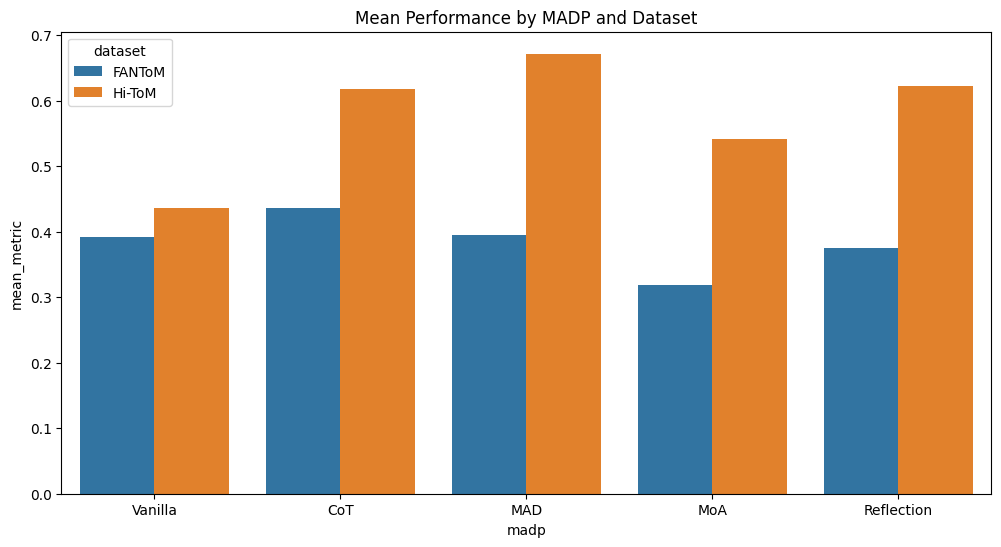

In [61]:
# Figures
# Bar plot RQ1
plt.figure(figsize=(12,6))
sns.barplot(data=agg_data, x='madp', y='mean_metric', hue='dataset', errorbar=None)
plt.title('Mean Performance by MADP and Dataset')
plt.savefig(RESULTS_DIR / 'madp_bar.png')

In [62]:
# Line plot RQ2 (MAD example)
mad_agg = agg_data[agg_data['madp'] == 'MAD']

In [63]:
mad_agg['rounds'] = np.nan
mad_agg['solvers'] = np.nan

/tmp/ipython-input-1652841461.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mad_agg['rounds'] = np.nan
/tmp/ipython-input-1652841461.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mad_agg['solvers'] = np.nan


In [64]:
for row, row_content in mad_agg.iterrows():
    config_ = mad_agg.loc[row, "config"].split(" ")
    rounds = int(config_[-2][-1])
    solvers = int(config_[-1][-1])
    mad_agg.loc[row, "rounds"] = rounds
    mad_agg.loc[row, "solvers"] = solvers

In [65]:
mad_agg

,dataset,question_type,config,madp,llm,mean_metric,std_metric,count,ci_lower,ci_upper,rounds,solvers
2,FANToM,AnswerabilityQ_List,<Rc3kmmq> MAD R1 S3,MAD,<Rc3kmmq>,0.477778,0.502304,90,0.374001,0.581555,1.0,3.0
3,FANToM,AnswerabilityQ_List,<Rc3kmmq> MAD R1 S5,MAD,<Rc3kmmq>,0.466667,0.501683,90,0.363018,0.570315,1.0,5.0
4,FANToM,AnswerabilityQ_List,<Rc3kmmq> MAD R1 S7,MAD,<Rc3kmmq>,0.477778,0.502304,90,0.374001,0.581555,1.0,7.0
5,FANToM,AnswerabilityQ_List,<Rc3kmmq> MAD R2 S3,MAD,<Rc3kmmq>,0.488889,0.502677,90,0.385035,0.592743,2.0,3.0
6,FANToM,AnswerabilityQ_List,<Rc3kmmq> MAD R2 S5,MAD,<Rc3kmmq>,0.444444,0.499688,90,0.341208,0.547681,2.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1463,Hi-ToM,Teller_Lie_Public_Claim,<qLKSiki> MAD R3 S3,MAD,<qLKSiki>,0.970588,0.170214,68,0.930131,1.011046,3.0,3.0
1464,Hi-ToM,Teller_Lie_Public_Claim,<qLKSiki> MAD R3 S5,MAD,<qLKSiki>,1.000000,0.000000,68,1.000000,1.000000,3.0,5.0
1465,Hi-ToM,Teller_Lie_Public_Claim,<qLKSiki> MAD R3 S7,MAD,<qLKSiki>,1.000000,0.000000,68,1.000000,1.000000,3.0,7.0
1481,Hi-ToM,Teller_Lie_Public_Claim,Mixed-A MAD R3 S7,MAD,Mixed,0.955882,0.206883,68,0.906709,1.005055,3.0,7.0


In [66]:
mad_agg.to_csv(RESULTS_DIR / "mad_agg.csv")

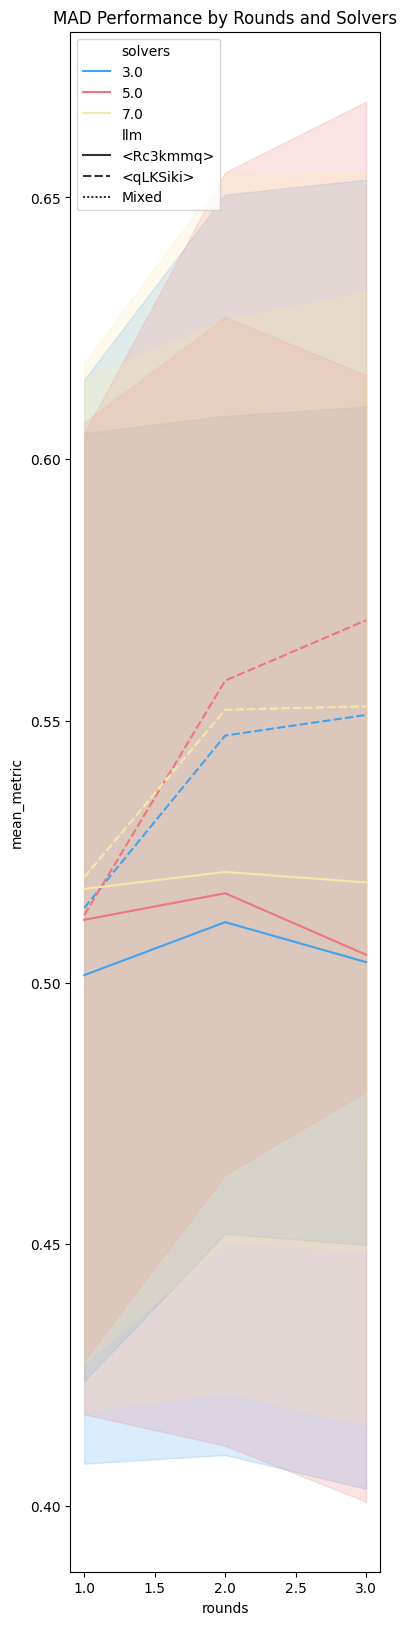

In [67]:
plt.figure(figsize=(4,20))
sns.lineplot(data=mad_agg, x='rounds', y='mean_metric', hue='solvers', palette = ["#43A3EF", "#EF767B", "#F9E7A7"],style='llm')
plt.title('MAD Performance by Rounds and Solvers')
plt.savefig(RESULTS_DIR / 'mad_lines.png')

/tmp/ipython-input-963091053.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moa_agg['layers'] = np.nan
/tmp/ipython-input-963091053.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moa_agg['workers'] = np.nan


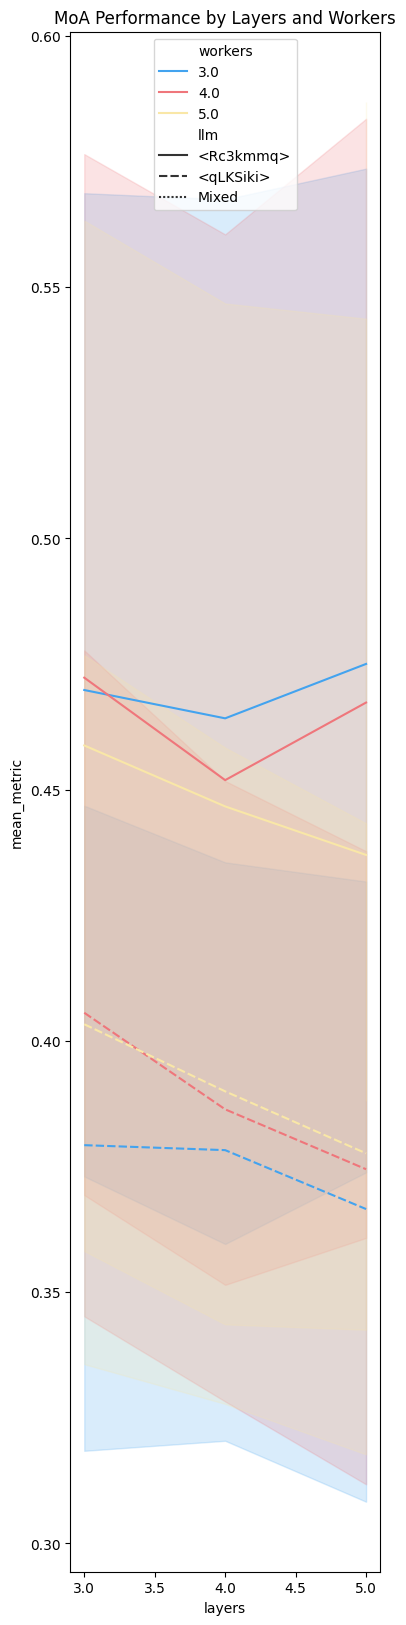

In [68]:
# Line plot RQ2 (MoA example)
moa_agg = agg_data[agg_data['madp'] == 'MoA']

moa_agg['layers'] = np.nan
moa_agg['workers'] = np.nan

for row, row_content in moa_agg.iterrows():
    config_ = moa_agg.loc[row, "config"].split(" ")
    workers = int(config_[-2][-1])
    layers = int(config_[-1][-1])
    moa_agg.loc[row, "workers"] = workers
    moa_agg.loc[row, "layers"] = layers

moa_agg.to_csv(RESULTS_DIR / "moa_agg.csv")

plt.figure(figsize=(4,20))
sns.lineplot(data=moa_agg, x='layers', y='mean_metric', hue='workers', palette = ["#43A3EF", "#EF767B", "#F9E7A7"], style='llm')
plt.title('MoA Performance by Layers and Workers')
plt.savefig(RESULTS_DIR / 'moa_lines.png')

/tmp/ipython-input-206286516.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reflection_agg['iters'] = np.nan


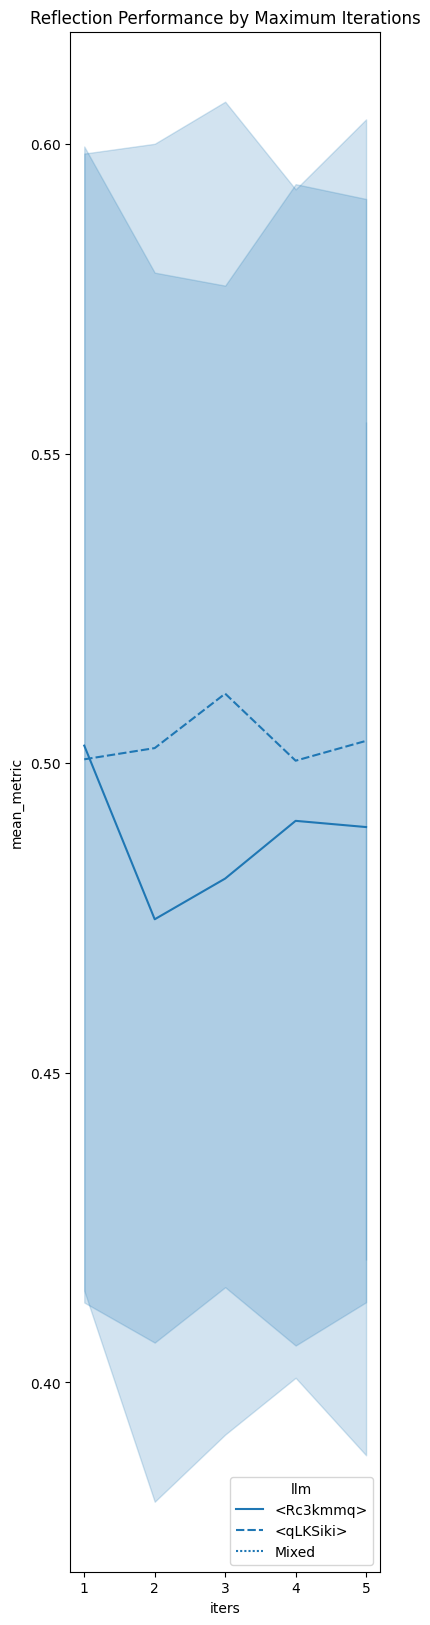

In [69]:
# Line plot RQ2 (Reflection example)
reflection_agg = agg_data[agg_data['madp'] == 'Reflection']

reflection_agg['iters'] = np.nan

for row, row_content in reflection_agg.iterrows():
    config_ = reflection_agg.loc[row, "config"].split(" ")
    iters = int(config_[-1][-1])
    reflection_agg.loc[row, "iters"] = iters

reflection_agg.to_csv(RESULTS_DIR / "reflection_agg.csv")

plt.figure(figsize=(4,20))
sns.lineplot(data=reflection_agg, x='iters', y='mean_metric', style='llm')
plt.title('Reflection Performance by Maximum Iterations')
plt.savefig(RESULTS_DIR / 'reflection_lines.png')

In [70]:
# Heatmap RQ5
pivot = agg_data.pivot(index='question_type', columns='config', values='mean_metric')

In [71]:
pivot

config,<Rc3kmmq>,<Rc3kmmq> + CoT,<Rc3kmmq> MAD R1 S3,<Rc3kmmq> MAD R1 S5,<Rc3kmmq> MAD R1 S7,<Rc3kmmq> MAD R2 S3,<Rc3kmmq> MAD R2 S5,<Rc3kmmq> MAD R2 S7,<Rc3kmmq> MAD R3 S3,<Rc3kmmq> MAD R3 S5,...,<qLKSiki> Reflection T1,<qLKSiki> Reflection T2,<qLKSiki> Reflection T3,<qLKSiki> Reflection T4,<qLKSiki> Reflection T5,Mixed MoA W5 L5,Mixed-A MAD R3 S7,Mixed-A Reflection T5,Mixed-B MAD R3 S7,Mixed-B Reflection T5
question_type,,,,,,,,,,,,,,,,,,,,,
AnswerabilityQ_List,0.400000,0.377778,0.477778,0.466667,0.477778,0.488889,0.444444,0.477778,0.488889,0.344444,...,0.533333,0.422222,0.466667,0.455556,0.433333,0.455556,0.511111,0.400000,0.500000,0.477778
AnswerabilityQs_Binary,0.521277,0.704787,0.521277,0.513298,0.518617,0.518617,0.518617,0.518617,0.510638,0.500000,...,0.819149,0.765957,0.792553,0.795213,0.805851,0.630319,0.635638,0.547872,0.654255,0.805851
BeliefQ_Choice_First_Order,0.194805,0.324675,0.311688,0.311688,0.272727,0.311688,0.324675,0.285714,0.350649,0.337662,...,0.428571,0.415584,0.415584,0.402597,0.402597,0.324675,0.350649,0.311688,0.350649,0.389610
BeliefQ_Choice_Second_Order_Acyclic,0.615385,0.730769,0.423077,0.461538,0.423077,0.500000,0.500000,0.423077,0.538462,0.461538,...,0.384615,0.423077,0.346154,0.461538,0.384615,0.576923,0.576923,0.346154,0.423077,0.384615
BeliefQ_Choice_Second_Order_Cyclic,0.518519,0.629630,0.444444,0.444444,0.481481,0.518519,0.555556,0.555556,0.518519,0.629630,...,0.481481,0.518519,0.518519,0.444444,0.407407,0.518519,0.629630,0.444444,0.407407,0.518519
BeliefQ_Dist_First_Order,0.090909,0.168831,0.064935,0.077922,0.064935,0.103896,0.116883,0.129870,0.077922,0.090909,...,0.246753,0.207792,0.259740,0.181818,0.181818,0.051948,0.194805,0.142857,0.168831,0.246753
BeliefQ_Dist_First_Order_TokenF1,0.288410,0.198939,0.279980,0.281583,0.281394,0.224359,0.214520,0.216096,0.204234,0.205016,...,0.234777,0.203108,0.203283,0.204831,0.192817,0.288471,0.223841,0.186890,0.218248,0.177432
BeliefQ_Dist_Second_Order_Acyclic,0.307692,0.461538,0.423077,0.423077,0.461538,0.461538,0.461538,0.461538,0.500000,0.384615,...,0.500000,0.615385,0.730769,0.653846,0.615385,0.153846,0.461538,0.346154,0.500000,0.730769
BeliefQ_Dist_Second_Order_Acyclic_TokenF1,0.239223,0.148561,0.221024,0.209044,0.199947,0.166551,0.165991,0.177312,0.161870,0.157411,...,0.177619,0.165067,0.170084,0.152529,0.154529,0.235472,0.169902,0.168257,0.161658,0.143536


In [72]:
pivot.round(2).to_csv(RESULTS_DIR / 'pivot_Heatmap.csv')

In [73]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ------- Load data -------
df = pd.read_csv(RESULTS_DIR / "pivot_Heatmap.csv")

# Clean up any stray whitespace in question_type values
if "question_type" in df.columns:
    df["question_type"] = df["question_type"].astype(str).str.strip()

# ------- Desired orders (as provided) -------
config_order = [
    "<qLKSiki>", "<qLKSiki> + CoT", "<Rc3kmmq>", "<Rc3kmmq> + CoT",
    "<qLKSiki> MAD R1 S3", "<qLKSiki> MAD R1 S5", "<qLKSiki> MAD R1 S7",
    "<qLKSiki> MAD R2 S3", "<qLKSiki> MAD R2 S5", "<qLKSiki> MAD R2 S7",
    "<qLKSiki> MAD R3 S3", "<qLKSiki> MAD R3 S5", "<qLKSiki> MAD R3 S7",
    "<Rc3kmmq> MAD R1 S3", "<Rc3kmmq> MAD R1 S5", "<Rc3kmmq> MAD R1 S7",
    "<Rc3kmmq> MAD R2 S3", "<Rc3kmmq> MAD R2 S5", "<Rc3kmmq> MAD R2 S7",
    "<Rc3kmmq> MAD R3 S3", "<Rc3kmmq> MAD R3 S5", "<Rc3kmmq> MAD R3 S7",
    "Mixed-A MAD R3 S7", "Mixed-B MAD R3 S7",
    "<qLKSiki> MoA W3 L3", "<qLKSiki> MoA W3 L4", "<qLKSiki> MoA W3 L5",
    "<qLKSiki> MoA W4 L3", "<qLKSiki> MoA W4 L4", "<qLKSiki> MoA W4 L5",
    "<qLKSiki> MoA W5 L3", "<qLKSiki> MoA W5 L4", "<qLKSiki> MoA W5 L5",
    "<Rc3kmmq> MoA W3 L3", "<Rc3kmmq> MoA W3 L4", "<Rc3kmmq> MoA W3 L5",
    "<Rc3kmmq> MoA W4 L3", "<Rc3kmmq> MoA W4 L4", "<Rc3kmmq> MoA W4 L5",
    "<Rc3kmmq> MoA W5 L3", "<Rc3kmmq> MoA W5 L4", "<Rc3kmmq> MoA W5 L5",
    "Mixed MoA W5 L5",
    "<qLKSiki> Reflection T1", "<qLKSiki> Reflection T2", "<qLKSiki> Reflection T3",
    "<qLKSiki> Reflection T4", "<qLKSiki> Reflection T5",
    "<Rc3kmmq> Reflection T1", "<Rc3kmmq> Reflection T2", "<Rc3kmmq> Reflection T3",
    "<Rc3kmmq> Reflection T4", "<Rc3kmmq> Reflection T5",
    "Mixed-A Reflection T5", "Mixed-B Reflection T5"
]

question_type_order = [
    "FactQ", "BeliefQ_Choice_First_Order", "BeliefQ_Choice_Second_Order_Cyclic",
    "BeliefQ_Choice_Second_Order_Acyclic", "BeliefQ_Dist_First_Order",
    "BeliefQ_Dist_First_Order_TokenF1", "BeliefQ_Dist_Second_Order_Cyclic",
    "BeliefQ_Dist_Second_Order_Cyclic_TokenF1", "BeliefQ_Dist_Second_Order_Acyclic",
    "BeliefQ_Dist_Second_Order_Acyclic_TokenF1", "AnswerabilityQ_List",
    "AnswerabilityQs_Binary", "Info_AccessQ_List", "Info_AccessQ_Binary",
    "Order_0", "Order_1", "Order_2", "Order_3", "Order_4",
    "Teller_Knowledge_Container_Public_Claim",
    "Teller_Knowledge_Container_Private_Communication",
    "Teller_Lie_Public_Claim", "Teller_Lie_Private_Communication",
    "Listener_Temporal_Public_Claim", "Listener_Temporal_Private_Communication",
    "Listener_Belief_Public_Claim", "Listener_Belief_Private_Communication"
]

# ------- Reshape to long format -------
df_long = df.melt(id_vars=["question_type"], var_name="config", value_name="value")

# Apply category ordering (strict)
df_long["config"] = pd.Categorical(df_long["config"], categories=config_order, ordered=True)
df_long["question_type"] = pd.Categorical(df_long["question_type"], categories=question_type_order, ordered=True)

# ------- Pivot in the specified order -------
heatmap_data = df_long.pivot(index="question_type", columns="config", values="value")
heatmap_data = heatmap_data.reindex(index=question_type_order, columns=config_order)

# ------- Plot (seaborn) -------
plt.figure(figsize=(28, 14))
ax = sns.heatmap(heatmap_data, annot=True, cmap='coolwarm')  # keep default colormap
ax.set_title("Performance Heatmap")
ax.set_xlabel("config")
ax.set_ylabel("question_type")
# plt.xticks(rotation=90)
# plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Save the figure
plt.savefig(RESULTS_DIR / 'heatmap.png', bbox_inches="tight", dpi=300)
plt.close()

In [74]:
bias_data

,Unnamed: 0.1,Unnamed: 0,set_id,config,result,metric,dataset,question_type,correct,yes,...,llm,rounds,layers,iters,solvers,workers,is_cot,is_baseline,forward_order,backward_order
0,98010,98010,NaN,<qLKSiki>,False,0.0,Hi-ToM,Order_0,NaN,NaN,...,<qLKSiki>,NaN,NaN,NaN,NaN,NaN,False,True,3.0,0.0
1,98011,98011,NaN,<qLKSiki>,True,1.0,Hi-ToM,Order_0,NaN,NaN,...,<qLKSiki>,NaN,NaN,NaN,NaN,NaN,False,True,0.0,3.0
2,98012,98012,NaN,<qLKSiki>,True,1.0,Hi-ToM,Order_0,NaN,NaN,...,<qLKSiki>,NaN,NaN,NaN,NaN,NaN,False,True,0.0,3.0
3,98013,98013,NaN,<qLKSiki>,True,1.0,Hi-ToM,Order_0,NaN,NaN,...,<qLKSiki>,NaN,NaN,NaN,NaN,NaN,False,True,0.0,1.0
4,98014,98014,NaN,<qLKSiki>,False,0.0,Hi-ToM,Order_0,NaN,NaN,...,<qLKSiki>,NaN,NaN,NaN,NaN,NaN,False,True,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38495,136505,136505,NaN,Mixed-B Reflection T5,True,1.0,Hi-ToM,Teller_Knowledge_Container_Private_Communication,NaN,NaN,...,Mixed,NaN,NaN,5.0,NaN,NaN,False,False,1.0,0.0
38496,136506,136506,NaN,Mixed-B Reflection T5,True,1.0,Hi-ToM,Teller_Knowledge_Container_Private_Communication,NaN,NaN,...,Mixed,NaN,NaN,5.0,NaN,NaN,False,False,2.0,4.0
38497,136507,136507,NaN,Mixed-B Reflection T5,True,1.0,Hi-ToM,Teller_Knowledge_Container_Private_Communication,NaN,NaN,...,Mixed,NaN,NaN,5.0,NaN,NaN,False,False,3.0,2.0
38498,136508,136508,NaN,Mixed-B Reflection T5,False,0.0,Hi-ToM,Teller_Knowledge_Container_Private_Communication,NaN,NaN,...,Mixed,NaN,NaN,5.0,NaN,NaN,False,False,4.0,4.0


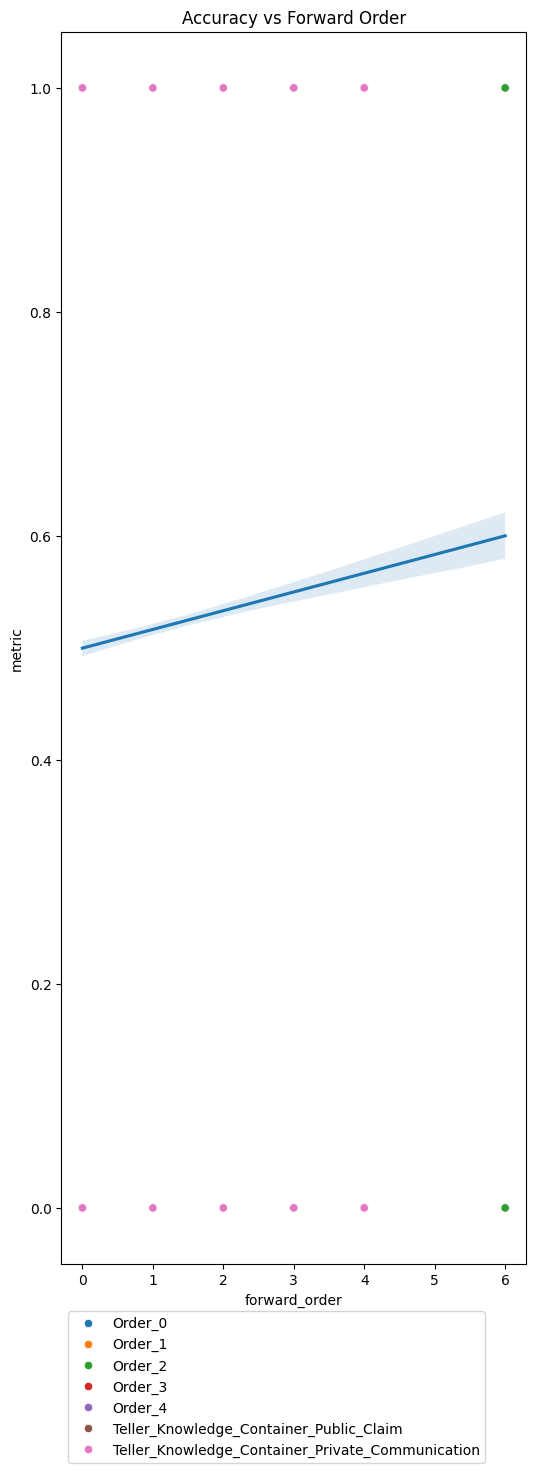

In [75]:
# Scatter for bias RQ4
plt.figure(figsize=(6,16))
g = sns.scatterplot(data=bias_data, x='forward_order', y='metric', hue='question_type')
g.legend(loc='center left', bbox_to_anchor=(0, -0.1), ncol=1)
sns.regplot(data=bias_data, x='forward_order', y='metric', scatter=False)
plt.title('Accuracy vs Forward Order')
plt.savefig(RESULTS_DIR / 'bias_scatter_forward_order.png', bbox_inches="tight")

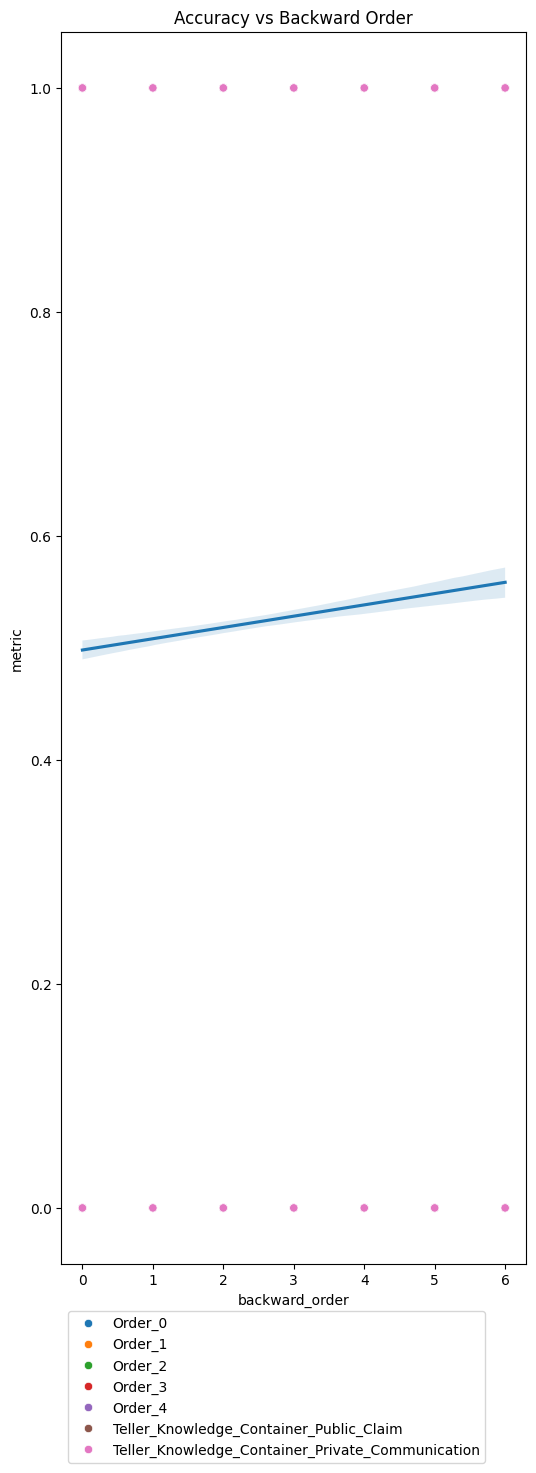

In [76]:
# Scatter for bias RQ4
plt.figure(figsize=(6,16))
g = sns.scatterplot(data=bias_data, x='backward_order', y='metric', hue='question_type')
g.legend(loc='center left', bbox_to_anchor=(0, -0.1), ncol=1)
sns.regplot(data=bias_data, x='backward_order', y='metric', scatter=False)
plt.title('Accuracy vs Backward Order')
plt.savefig(RESULTS_DIR / 'bias_scatter_backward_order.png', bbox_inches="tight")

In [77]:
if not os.path.exists(RESULTS_DIR / "tce_model.nc"):
    import pymc.sampling.jax as pmjax

In [78]:
if not os.path.exists(RESULTS_DIR / "tce_model.nc"):
    # Bayesian Hierarchical Model (TCE) using PyMC
    with pm.Model() as tce_model:
        # Hyperpriors for random effects
        alpha_sd = pm.HalfNormal('alpha_sd', sigma=2)
        gamma_sd = pm.HalfNormal('gamma_sd', sigma=2)

        # Fixed effects
        beta0 = pm.Normal('beta0', mu=0, sigma=5)
        beta1 = pm.Normal('beta1', mu=0, sigma=2)  # param_complexity
        beta2 = pm.Normal('beta2', mu=0, sigma=2)  # llm_size

        # Random effects
        alpha = pm.Normal('alpha', mu=0, sigma=alpha_sd, shape=len(madp_uniques))
        gamma = pm.Normal('gamma', mu=0, sigma=gamma_sd, shape=len(qtype_uniques))

        # Linear model
        logit_p = beta0 + beta1 * binary_data['param_complexity'].values + beta2 * binary_data['llm_size'].values + \
                  alpha[binary_data['madp_idx'].values] + gamma[binary_data['qtype_idx'].values]

        # Likelihood
        pm.Bernoulli('accuracy', logit_p=logit_p, observed=binary_data['metric'].values)

        # Sample
        # trace = pm.sample(1000, tune=1000, target_accept=0.9, random_seed=42, cores=4)
        trace = pmjax.sample_numpyro_nuts(
            1000,
            tune=1000,
            target_accept=0.9,
            random_seed=42,
            # cores=4
        )

        trace.to_netcdf(f"{RESULTS_DIR}/tce_model.nc")
else:
    trace = az.from_netcdf(f"{RESULTS_DIR}/tce_model.nc")


In [79]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [81]:
# pm.model_to_graphviz(tce_model)

In [82]:
# Summarize and save
summary = az.summary(trace)

In [83]:
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,-0.028,0.379,-0.730,0.659,0.016,0.014,583.0,818.0,1.00
beta1,0.009,0.001,0.007,0.011,0.000,0.000,4221.0,2529.0,1.00
beta2,-0.168,0.012,-0.189,-0.145,0.000,0.000,4518.0,3064.0,1.00
alpha[0],0.321,0.274,-0.207,0.817,0.008,0.012,1148.0,921.0,1.00
alpha[1],0.307,0.273,-0.218,0.790,0.008,0.012,1169.0,928.0,1.00
alpha[2],-0.464,0.274,-0.962,0.044,0.008,0.012,1162.0,913.0,1.00
alpha[3],0.204,0.273,-0.322,0.693,0.008,0.012,1167.0,931.0,1.00
alpha[4],-0.350,0.274,-0.877,0.139,0.008,0.012,1178.0,917.0,1.00
gamma[0],-0.133,0.260,-0.599,0.359,0.013,0.009,426.0,603.0,1.01
gamma[1],0.473,0.259,-0.005,0.956,0.013,0.009,414.0,563.0,1.01


In [84]:
summary.to_csv(RESULTS_DIR / 'tce_summary.csv')

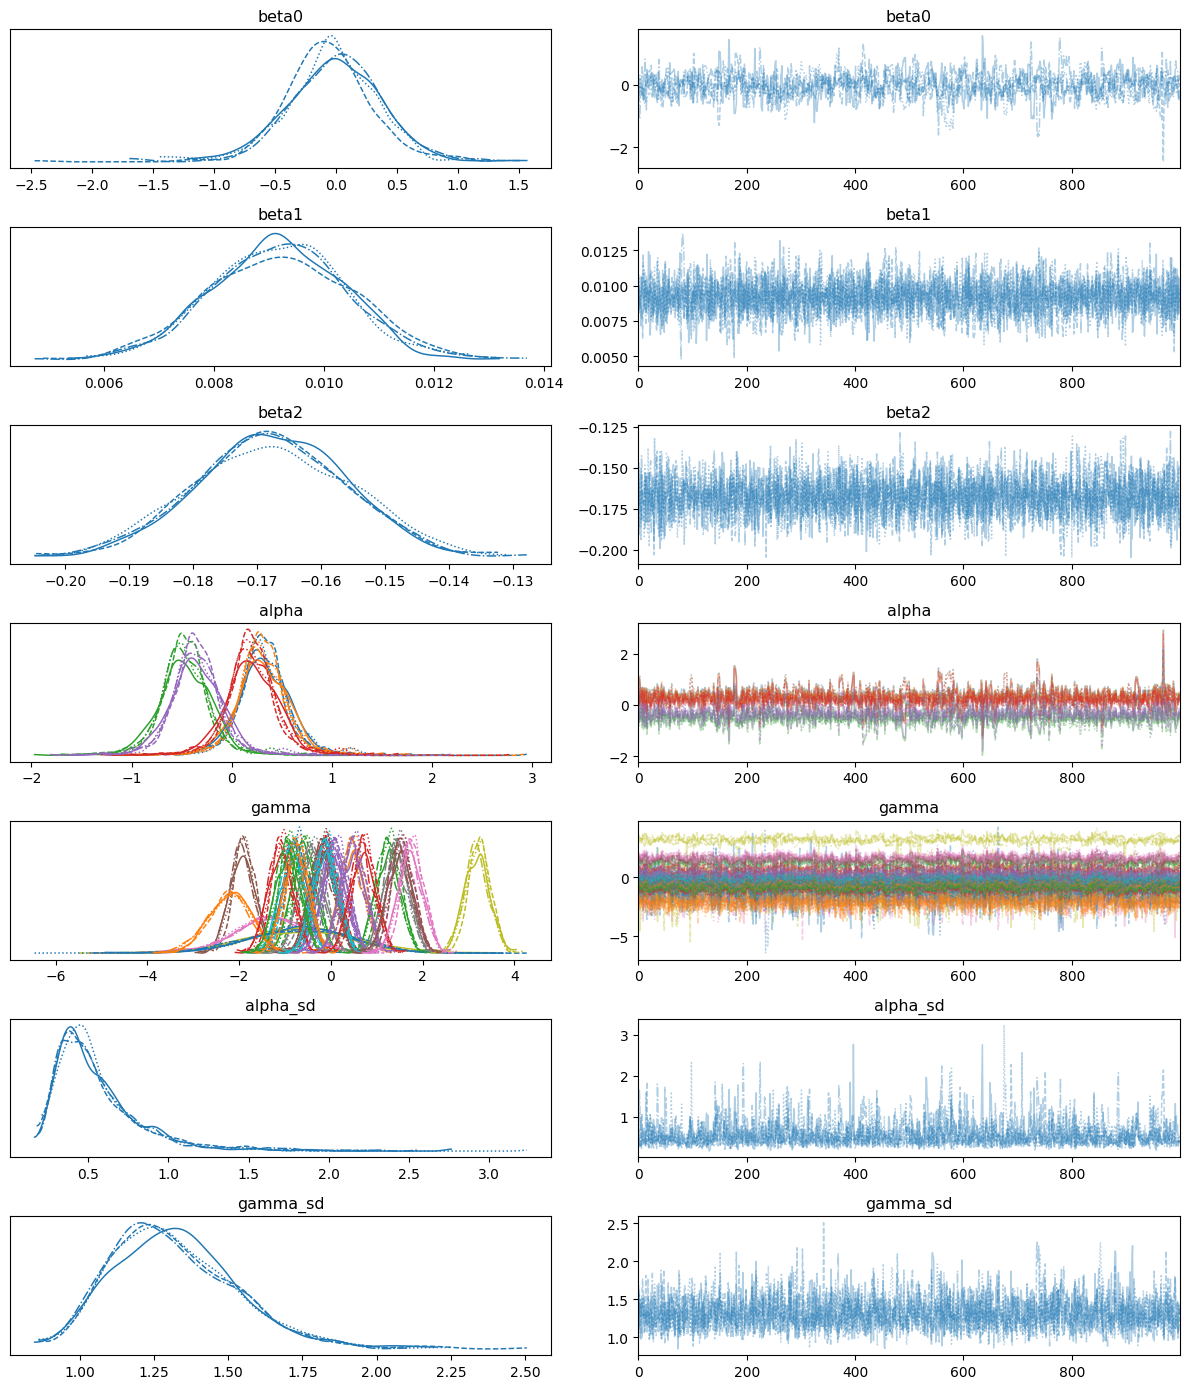

In [85]:
# Plot trace
az.plot_trace(trace)
fig = plt.gcf()
fig.tight_layout()
plt.savefig(RESULTS_DIR / 'tce_trace.png')